### Overview
This notebook works on the IEEE-CIS Fraud Detection competition. Here I build a simple XGBoost model based on a balanced dataset.

### Lessons:

. keep the categorical variables as single items

. Use a high max_depth for xgboost (maybe 40)


### Ideas to try:

. train divergence of expected value (eg. for TransactionAmt and distance based on the non-fraud subset (not all subset as in the case now)

. try using a temporal approach to CV

In [1]:
# all imports necessary for this notebook
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import gc
import copy
import missingno as msno 
import xgboost
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split 
from sklearn.metrics import roc_auc_score, r2_score

import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/ieee-fraud-detection/train_identity.csv
/kaggle/input/ieee-fraud-detection/train_transaction.csv
/kaggle/input/ieee-fraud-detection/test_transaction.csv
/kaggle/input/ieee-fraud-detection/test_identity.csv
/kaggle/input/ieee-fraud-detection/sample_submission.csv


In [2]:
# Helpers
    
def seed_everything(seed=0):
    '''Seed to make all processes deterministic '''
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
def drop_correlated_cols(df, threshold, sample_frac = 1):
    '''Drops one of two dataframe's columns whose pairwise pearson's correlation is above the provided threshold'''
    if sample_frac != 1:
        dataset = df.sample(frac = sample_frac).copy()
    else:
        dataset = df
        
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        if corr_matrix.columns[i] in col_corr:
            continue
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
    del dataset
    gc.collect()
    df.drop(columns = col_corr, inplace = True)


In [3]:
seed_everything()
pd.set_option('display.max_columns', 500)

In [4]:
#read data
folder_path = '/kaggle/input/ieee-fraud-detection/'
train_identity = pd.read_csv(f'{folder_path}train_identity.csv')
train_transaction = pd.read_csv(f'{folder_path}train_transaction.csv')
test_identity = pd.read_csv(f'{folder_path}test_identity.csv')
test_transaction = pd.read_csv(f'{folder_path}test_transaction.csv')
sample_submission = pd.read_csv(f'{folder_path}sample_submission.csv')
# Merge identity and transaction data 
train_df = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test_df = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

del train_identity, train_transaction, test_identity, test_transaction
gc.collect()

11

In [5]:
print(train_df.shape)
print(test_df.shape)
gc.collect()

(590540, 434)
(506691, 433)


0

In [6]:
df_missing = pd.DataFrame((train_df.isnull().mean() * 100), columns=['missing_perc_train'])
test_missing = (test_df.isnull().mean() * 100)
df_missing = df_missing.join(test_missing.rename('missing_perc_test')).reset_index()
df_missing.rename(columns = {'index' :'Feature'}, inplace=True)
df_missing['missing_percent_avg'] = (df_missing['missing_perc_train'] + df_missing['missing_perc_test']) / 2
df_missing.sort_values(by=['missing_percent_avg', 'missing_perc_train', 'missing_perc_test'], inplace=True)
#df_missing['abs_missing_percent_diff'] = np.abs(df_missing['missing_perc_train'] - df_missing['missing_perc_test'])
#df_missing.sort_values(by=['abs_missing_percent_diff'], ascending=False)
print(df_missing.shape)
df_missing.head()

(434, 4)


,Feature,missing_perc_train,missing_perc_test,missing_percent_avg
0,TransactionID,0.0,0.0,0.0
2,TransactionDT,0.0,0.0,0.0
3,TransactionAmt,0.0,0.0,0.0
4,ProductCD,0.0,0.0,0.0
5,card1,0.0,0.0,0.0


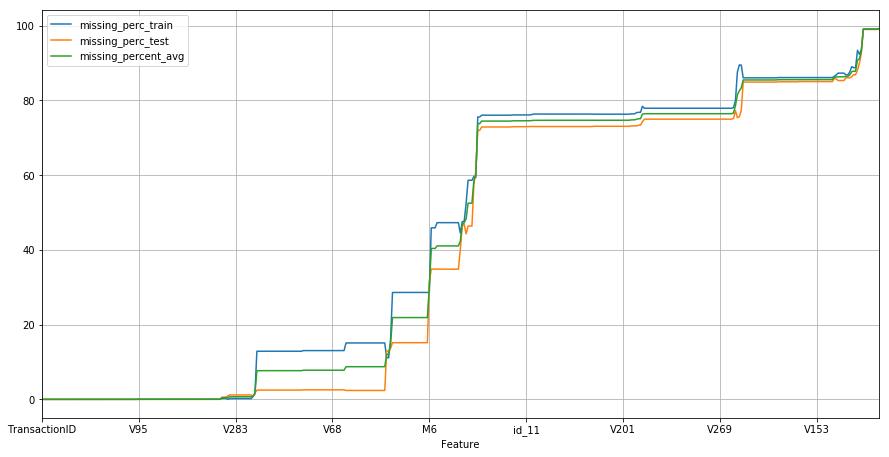

In [7]:
df_missing[~df_missing.Feature.str.contains('isFraud')].set_index('Feature').plot(figsize=(15,7.5), grid=True)

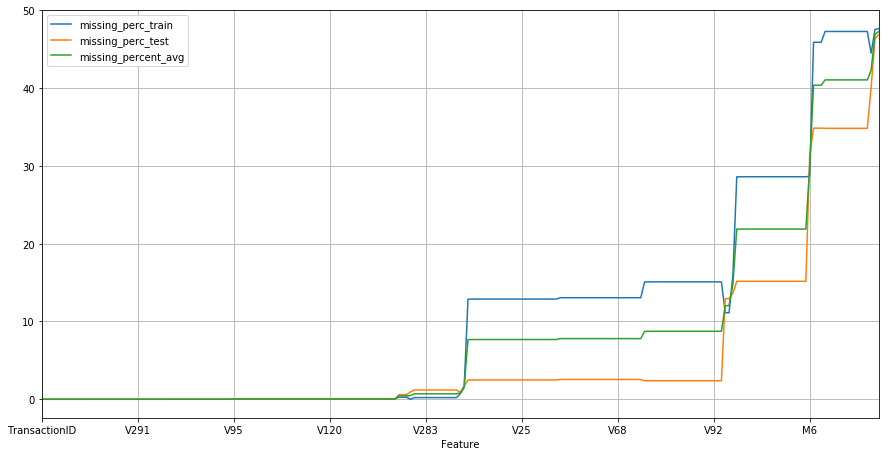

In [8]:
df_missing[~df_missing.Feature.str.contains('isFraud')].loc[df_missing.missing_perc_train<50].set_index('Feature').plot(figsize=(15,7.5), grid=True)
#df_missing.loc[df_missing.missing_perc_train<50].shape

In [9]:
gc.collect()

0

In [10]:
train_df['is_train_df'] = 1
test_df['is_train_df'] = 0
print(train_df.shape)
print(test_df.shape)

(590540, 435)
(506691, 434)


In [11]:
cols_orig_train = train_df.columns
master_df = pd.concat([train_df, test_df], ignore_index=True, sort =True).reindex(columns=cols_orig_train)
print(master_df.shape)
#master_df.head()

(1097231, 435)


In [12]:
#master_df = master_df.sample(frac = 1)

In [13]:
drop_correlated = False
if drop_correlated:
    %%time
    print(master_df.shape)
    temp_df_must_keep = master_df[['TransactionID', 'TransactionDT', 'isFraud', 'is_train_df']].copy()
    drop_correlated_cols(master_df, 0.95, sample_frac = 0.5)
    cols_to_use = master_df.columns.difference(temp_df_must_keep.columns)
    master_df = pd.merge(temp_df_must_keep, master_df[cols_to_use], left_index=True, right_index=True, how='left', validate = 'one_to_one')
    master_df.sort_values(by=['TransactionID', 'TransactionDT'], inplace=True)
    gc.collect()
    print(master_df.shape)
    master_df.head()

In [14]:
if drop_correlated:
    del temp_df_must_keep
    gc.collect()

In [15]:
master_df.sort_values(by=['TransactionID', 'TransactionDT'], inplace=True)
gc.collect()

0

In [16]:
del test_df, train_df
gc.collect()

0

In [17]:
cols_all = set(master_df.columns)

cols_target = 'isFraud'

cols_cat = {'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 
            'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 
            'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo', 'ProductCD', 'card4', 
            'card6', 'M4','P_emaildomain',  'R_emaildomain', 'card1', 'card2', 'card3',  'card5', 'addr1', 
            'addr2', 'M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9'}

cols_cont = set([col for col in cols_all if col not in cols_cat and col != cols_target] )
# cols_cont.remove(cols_target)
print(len(cols_cat))
print(len(cols_cont))
print(len(cols_cat) + len(cols_cont))

49
385
434


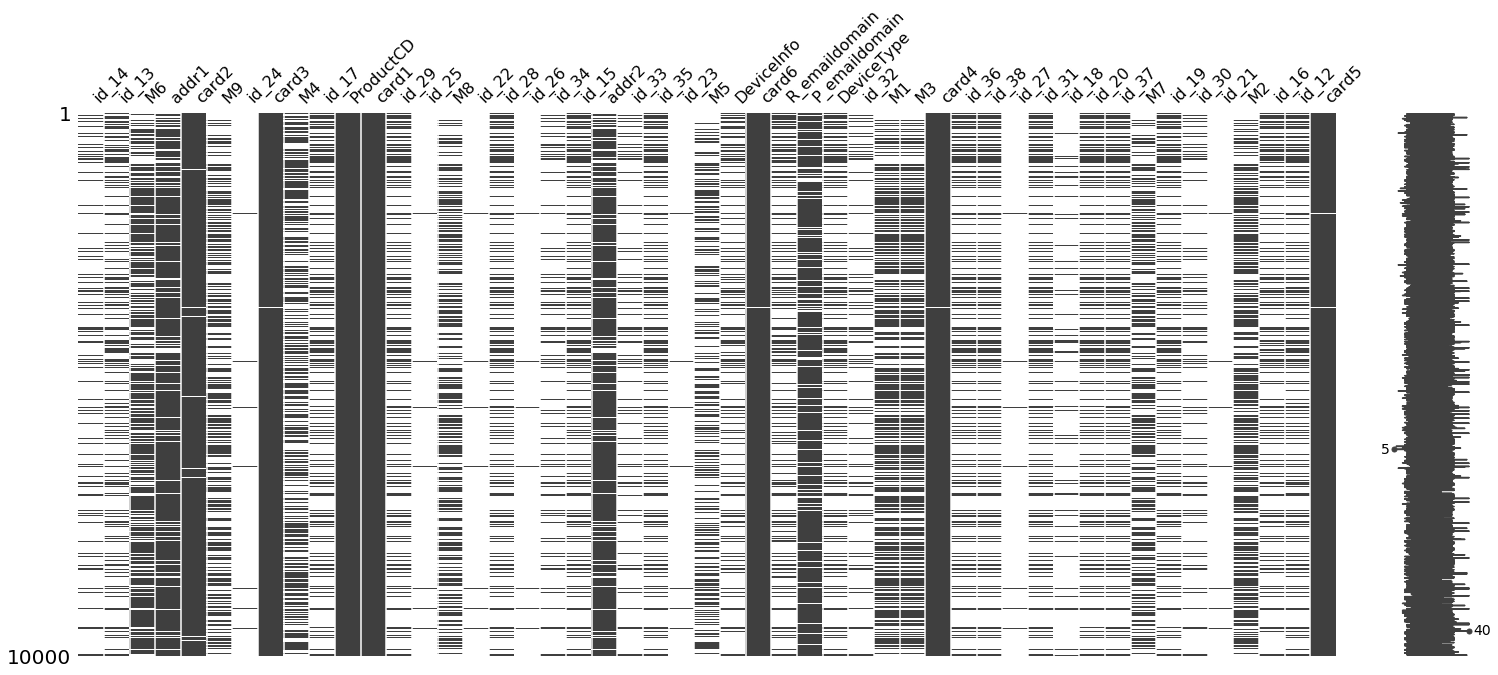

In [18]:
msno.matrix(master_df[cols_cat].sample(10000))

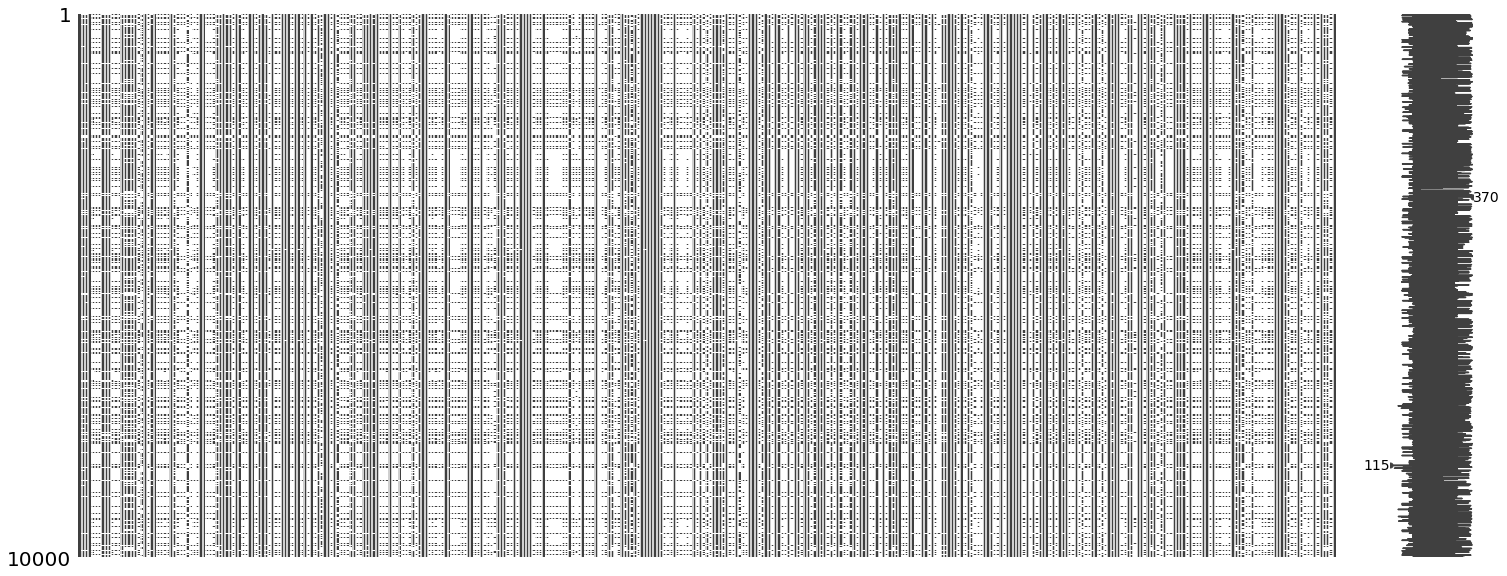

In [19]:
msno.matrix(master_df[cols_cont].sample(10000))

In [20]:
master_df.loc[:, cols_cat] = master_df.loc[:, cols_cat].astype('category')

In [21]:
# Some FE
master_df[['P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3']] = master_df['P_emaildomain'].str.split('.', expand=True)
master_df[['R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3']] = master_df['R_emaildomain'].str.split('.', expand=True)
master_df['P_emaildomain_4'] = master_df['P_emaildomain'].str.replace('^[^.]+.', '', regex=True)
master_df['R_emaildomain_4'] = master_df['R_emaildomain'].str.replace('^[^.]+.', '', regex=True)
cols_cat.update(['P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3', 'P_emaildomain_4', 'R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3', 'R_emaildomain_4'])

In [22]:
print('P_emaildomain_1', master_df['P_emaildomain_1'].unique())
print(80 * '-')
print('P_emaildomain_2', master_df['P_emaildomain_2'].unique())
print(80 * '-')
print('P_emaildomain_3', master_df['P_emaildomain_3'].unique())
print(80 * '-')
print('P_emaildomain_4', master_df['P_emaildomain_4'].unique())

P_emaildomain_1 [nan 'gmail' 'outlook' 'yahoo' 'mail' 'anonymous' 'hotmail' 'verizon'
 'aol' 'me' 'comcast' 'optonline' 'cox' 'charter' 'rocketmail' 'prodigy'
 'embarqmail' 'icloud' 'live' 'att' 'juno' 'ymail' 'sbcglobal' 'bellsouth'
 'msn' 'q' 'centurylink' 'servicios-ta' 'earthlink' 'cfl' 'roadrunner'
 'netzero' 'gmx' 'suddenlink' 'frontiernet' 'windstream' 'frontier' 'mac'
 'aim' 'web' 'twc' 'cableone' 'sc' 'ptd' 'protonmail' 'scranton']
--------------------------------------------------------------------------------
P_emaildomain_2 [nan 'com' 'net' None 'es' 'rr' 'de' 'fr' 'co' 'edu']
--------------------------------------------------------------------------------
P_emaildomain_3 [nan None 'mx' 'com' 'uk' 'jp']
--------------------------------------------------------------------------------
P_emaildomain_4 [nan 'com' 'net' 'net.mx' 'com.mx' '' 'es' 'rr.com' 'de' 'fr' 'co.uk'
 'co.jp' 'edu']


In [23]:
print(master_df.loc[:, master_df.dtypes == object].shape)
print(len(cols_cat))

temp_missing_cat = master_df.loc[:, cols_cat].isnull().sum()
temp_missing_cat.sort_values(inplace=True)

temp_missing_cat_train = master_df.loc[master_df['is_train_df'] ==1 , cols_cat].isnull().sum()
temp_missing_cat_test = master_df.loc[master_df['is_train_df'] ==0 , cols_cat].isnull().sum()

temp_len = len(master_df)
temp_len_train = len(master_df.loc[master_df['is_train_df'] ==1])
temp_len_test = len(master_df.loc[master_df['is_train_df'] ==0])

for col in temp_missing_cat.index:
    
    temp_missing_percent = temp_missing_cat[col] * 100 / temp_len
    temp_missing_percent_train = temp_missing_cat_train[col] * 100 / temp_len_train
    temp_missing_percent_test = temp_missing_cat_test[col] * 100 / temp_len_test
    print("\n%s, missing is: %.1f%% (train: %.1f%%, test: %.1f%%), n_unique is: %s\n" 
          %(col, temp_missing_percent, temp_missing_percent_train, temp_missing_percent_test,  len(master_df.loc[:, col].unique()) ))
    temp_unique_list = master_df.loc[master_df[col].notnull(), col].astype(str).unique()
    temp_unique_list.sort()
    print(master_df.loc[:, col].value_counts().iloc[0:10])
    print(80* '-')
    print(80* '-')

(1097231, 8)
57

ProductCD, missing is: 0.0% (train: 0.0%, test: 0.0%), n_unique is: 5

W    800657
C    137785
R     73346
H     62397
S     23046
Name: ProductCD, dtype: int64
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------

card1, missing is: 0.0% (train: 0.0%, test: 0.0%), n_unique is: 17091

7919     28015
9500     26243
15885    22691
17188    19606
15066    14606
6019     13268
12695    12732
12544    12694
2803     11043
7585     10097
Name: card1, dtype: int64
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------

card3, missing is: 0.4% (train: 0.3%, test: 0.6%), n_unique is: 134

150.0    956845
185.0    109960
106.0      3543
117.0      2841
144.0      2633
146.0      2470
143.0      1670
102.0      1198
119.0      1091
162.0      1039
Name: card3, dtype: 

Further FE

In [24]:
#focus on id_31
master_df.id_31.astype(str).value_counts()[0:20]

nan                        820324
mobile safari 11.0          23655
chrome 63.0                 22168
chrome 70.0                 16054
ie 11.0 for desktop         14203
mobile safari 12.0          13098
mobile safari generic       11474
chrome 71.0                  9489
chrome 69.0                  8294
safari generic               8195
chrome 70.0 for android      7624
chrome 62.0                  7283
chrome 65.0                  7114
chrome 64.0                  6822
chrome 68.0                  6449
chrome 67.0                  6155
chrome 69.0 for android      6022
chrome 63.0 for android      5993
chrome 71.0 for android      5029
edge 17.0                    4945
Name: id_31, dtype: int64

In [25]:
#lowercase the whole column
master_df['id_31'] = master_df['id_31'].loc[master_df['id_31'].notnull()].str.lower()

In [26]:
temp = list(master_df['id_31'].unique())

temp.remove(np.nan)
#print(temp)
new_temp = []
import re
#DATA = "Hey, you - what are you doing here!?"
#print re.findall(r"[\w']+", DATA)
for item in temp:
    #new_temp.extend(item.split())
    new_temp.extend(re.findall(r"[\w']+", item))
new_temp
from collections import Counter
most_common_words= [word for word, word_count in Counter(new_temp).most_common(1000)]

#remove digits
most_common_words= [word for word in most_common_words if not word.isdigit()]

#remove single letter words
most_common_words= [word for word in most_common_words if len(word) > 1]

print(most_common_words)

['chrome', 'for', 'android', 'firefox', 'samsung', 'google', 'browser', 'safari', 'search', 'application', 'mobile', 'ios', 'generic', 'opera', 'edge', 'ie', 'sm', 'uiwebview', 'desktop', 'tablet', 'other', 'webview', 'g532m', 'aol', 'sch', 'silk', 'g531h', 'waterfox', 'nokia', 'lumia', 'puffin', 'microsoft', 'windows', 'cyberfox', 'zte', 'blade', 'palemoon', 'maxthon', 'line', 'lg', 'iron', 'blu', 'dash', 'seamonkey', 'm4tel', 'm4', 'comodo', 'lanix', 'ilium', 'chromium', 'inco', 'minion', 'mozilla', 'cherry', 'icedragon', 'facebook', 'rim', 'uc', 'blackberry']


In [27]:
temp_min_n_in_cat_to_keep = 1000

temp_added_cols = set()

for word in most_common_words:
    temp_len = len(master_df['id_31'].loc[master_df['id_31'].notnull() & master_df['id_31'].str.contains(word)])
    if temp_len >= temp_min_n_in_cat_to_keep:
        print("%s: %d \n" %(word, temp_len))
        temp_new_col_name = 'id_31' + '_' + word 
        master_df[temp_new_col_name] = master_df['id_31'].str.contains(word)
        temp_added_cols.add(temp_new_col_name)
        print(master_df[temp_new_col_name].describe())
        print(80* '-')

chrome: 155502 

count     276907
unique         2
top         True
freq      155502
Name: id_31_chrome, dtype: object
--------------------------------------------------------------------------------
for: 67953 

count     276907
unique         2
top        False
freq      208954
Name: id_31_for, dtype: object
--------------------------------------------------------------------------------
android: 50994 

count     276907
unique         2
top        False
freq      225913
Name: id_31_android, dtype: object
--------------------------------------------------------------------------------
firefox: 14393 

count     276907
unique         2
top        False
freq      262514
Name: id_31_firefox, dtype: object
--------------------------------------------------------------------------------
samsung: 4787 

count     276907
unique         2
top        False
freq      272120
Name: id_31_samsung, dtype: object
--------------------------------------------------------------------------------
googl

In [28]:
cols_cat = cols_cat.union(temp_added_cols)
#cols_cat

In [29]:
corr = master_df[temp_added_cols].astype('float16').corr()
corr.style.background_gradient(cmap='coolwarm')

,id_31_ios,id_31_mobile,id_31_for,id_31_generic,id_31_tablet,id_31_desktop,id_31_search,id_31_ie,id_31_edge,id_31_application,id_31_android,id_31_chrome,id_31_firefox,id_31_google,id_31_safari,id_31_samsung,id_31_browser
id_31_ios,1,-0.0477713,0.171218,-0.0315251,-0.00678318,-0.0227031,-0.00800109,-0.0245533,-0.0207677,-0.00800109,-0.0463893,0.0862739,-0.0228628,-0.00862912,-0.0567197,-0.0129503,-0.0129476
id_31_mobile,-0.0477713,1,-0.279008,0.201025,-0.0339893,-0.113761,-0.040092,-0.11928,-0.104063,-0.040092,-0.232449,-0.553717,-0.105371,-0.043239,0.837159,-0.0648917,-0.0648779
id_31_for,0.171218,-0.279008,1,-0.150885,0.121822,0.407735,-0.0467303,0.407751,-0.121294,-0.0467303,0.807382,0.241174,-0.13353,-0.0503983,-0.331271,-0.0756363,-0.0756203
id_31_generic,-0.0315251,0.201025,-0.150885,1,-0.0224301,-0.0750729,-0.0264574,-0.0811911,-0.0686731,-0.0264574,-0.1121,-0.21765,-0.0694804,-0.0285341,0.371763,-0.0229234,-0.0229103
id_31_tablet,-0.00678318,-0.0339893,0.121822,-0.0224301,1,-0.0161533,-0.00569278,0.276263,-0.0147763,-0.00569278,-0.033006,-0.0786238,-0.0162669,-0.00613962,-0.0403561,-0.00921416,-0.0092122
id_31_desktop,-0.0227031,-0.113761,0.407735,-0.0750729,-0.0161533,1,-0.0190536,0.924646,-0.0494557,-0.0190536,-0.11047,-0.263152,-0.0544448,-0.0205492,-0.135071,-0.0308396,-0.030833
id_31_search,-0.00800109,-0.040092,-0.0467303,-0.0264574,-0.00569278,-0.0190536,1,-0.0206064,-0.0174293,1,-0.0389322,-0.0927405,-0.0191875,0.927219,-0.0476019,-0.0108685,-0.0108662
id_31_ie,-0.0245533,-0.11928,0.407751,-0.0811911,0.276263,0.924646,-0.0206064,1,-0.0534862,-0.0206064,-0.08918,-0.284598,-0.0588818,-0.0222238,-0.142668,-0.0333528,-0.0333458
id_31_edge,-0.0207677,-0.104063,-0.121294,-0.0686731,-0.0147763,-0.0494557,-0.0174293,-0.0534862,1,-0.0174293,-0.101053,-0.240719,-0.0498035,-0.0187974,-0.123556,-0.0282105,-0.0282045
id_31_application,-0.00800109,-0.040092,-0.0467303,-0.0264574,-0.00569278,-0.0190536,1,-0.0206064,-0.0174293,1,-0.0389322,-0.0927405,-0.0191875,0.927219,-0.0476019,-0.0108685,-0.0108662


In [30]:
gc.collect()

12

In [31]:
master_df['id_31'].loc[master_df['id_31_chrome']== True].loc[master_df['id_31_android']== True].value_counts()

chrome 70.0 for android       7624
chrome 69.0 for android       6022
chrome 63.0 for android       5993
chrome 71.0 for android       5029
chrome 64.0 for android       3735
chrome 65.0 for android       3659
chrome 67.0 for android       3637
chrome 68.0 for android       3520
chrome 66.0 for android       2941
chrome 62.0 for android       2240
chrome generic for android    1158
chrome 55.0 for android        814
chrome 61.0 for android        622
chrome 56.0 for android        424
chrome 58.0 for android        402
chrome 60.0 for android        396
chrome 59.0 for android        336
chrome 50.0 for android        268
chrome 52.0 for android        181
chrome 43.0 for android        170
chrome 46.0 for android        123
chrome 57.0 for android        113
chrome 54.0 for android        102
chrome 53.0 for android         96
chrome 49.0 for android         69
chrome 39.0 for android         66
chrome 51.0 for android         65
Name: id_31, dtype: int64

In [32]:
master_df['id_31_chrome_version'] = master_df['id_31'].loc[master_df['id_31_chrome'] & 
                                                           (master_df['id_31_generic']==False)].str.slice(start=7, stop=9)
master_df['id_31_chrome_version'].loc[master_df['id_31_chrome_version'] ==''] = np.nan
#master_df[['id_31', 'id_31_chrome_version']].loc[master_df['id_31_chrome_version'].notnull()].head(20)
master_df['id_31_chrome_version'].value_counts()

63    28428
70    24343
71    14939
69    14620
65    10883
64    10618
68    10278
67    10013
62     9604
66     7725
61     1320
49     1150
55      936
60      820
58      664
56      599
59      543
50      268
57      239
52      181
43      170
51      141
46      123
54      102
53       96
39       66
Name: id_31_chrome_version, dtype: int64

In [33]:
rolling_window = 1000
min_rolling_window = 10
temp_df = master_df[['id_31_chrome_version']].loc[master_df['id_31_chrome_version'].notnull()].astype('float16')
temp_df['id_31_chrome_version_newness'] = temp_df['id_31_chrome_version'] / temp_df['id_31_chrome_version'].rolling(rolling_window, center= True, min_periods=min_rolling_window).mean()
#train_df[new_col_name] = train_df[col] / train_df[col].rolling(rolling_window, center= True, min_periods=min_rolling_window).mean().interpolate()

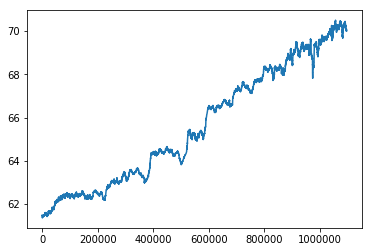

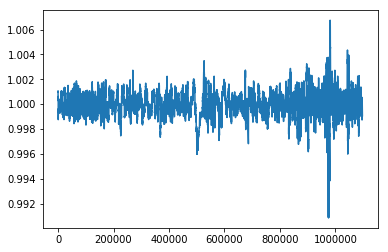

In [34]:
plt.plot(temp_df['id_31_chrome_version'].rolling(rolling_window, center= True, min_periods=min_rolling_window).mean())
plt.show()
plt.plot(temp_df['id_31_chrome_version_newness'].rolling(rolling_window, center= True, min_periods=min_rolling_window).mean())

In [35]:
master_df['id_31_chrome_version_newness'] = temp_df['id_31_chrome_version_newness']
master_df.drop(columns=['id_31_chrome_version'], inplace=True)
del temp_df
gc.collect()
cols_cont.add('id_31_chrome_version_newness')

In [36]:
master_df['id_31'].loc[master_df['id_31_safari']== True].value_counts()

mobile safari 11.0         23655
mobile safari 12.0         13098
mobile safari generic      11474
safari generic              8195
mobile safari 10.0          3933
safari 12.0                 3550
safari 11.0                 3447
safari 10.0                 1058
mobile safari 9.0            896
safari 9.0                   339
mobile safari uiwebview       97
mobile safari 8.0             88
safari                        36
Name: id_31, dtype: int64

In [37]:
master_df['id_31_safari_version'] = np.nan
master_df['id_31_safari_version'].loc[master_df['id_31'].notnull() & master_df['id_31'].str.contains('safari 8.0')] = 8
master_df['id_31_safari_version'].loc[master_df['id_31'].notnull() & master_df['id_31'].str.contains('safari 9.0')] = 9
master_df['id_31_safari_version'].loc[master_df['id_31'].notnull() & master_df['id_31'].str.contains('safari 10.0')] = 10
master_df['id_31_safari_version'].loc[master_df['id_31'].notnull() & master_df['id_31'].str.contains('safari 11.0')] = 11
master_df['id_31_safari_version'].loc[master_df['id_31'].notnull() & master_df['id_31'].str.contains('safari 12.0')] = 12

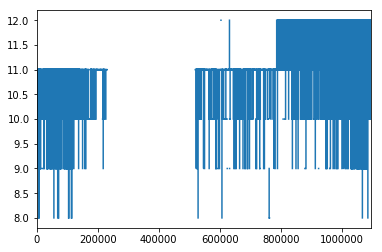

In [38]:
master_df['id_31_safari_version'].plot()

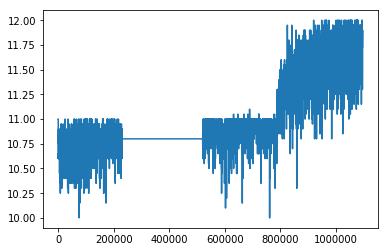

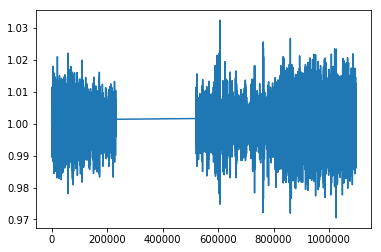

In [39]:
rolling_window = 20
min_rolling_window = 10
temp_df = master_df[['id_31_safari_version']].loc[master_df['id_31_safari_version'].notnull()].astype('float16')
temp_df['id_31_safari_version_newness'] = temp_df['id_31_safari_version'] / temp_df['id_31_safari_version'].rolling(rolling_window, center= True, min_periods=min_rolling_window).mean()
#train_df[new_col_name] = train_df[col] / train_df[col].rolling(rolling_window, center= True, min_periods=min_rolling_window).mean().interpolate()

plt.plot(temp_df['id_31_safari_version'].rolling(rolling_window, center= True, min_periods=min_rolling_window).mean())
plt.show()
plt.plot(temp_df['id_31_safari_version_newness'].rolling(rolling_window, center= True, min_periods=min_rolling_window).mean())

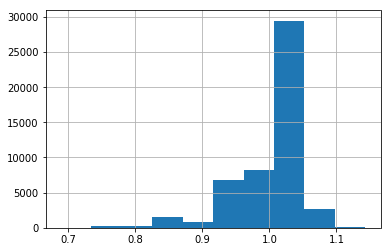

In [40]:
temp_df['id_31_safari_version_newness'].hist()

In [41]:
master_df['id_31_safari_version_newness'] = temp_df['id_31_safari_version_newness']
master_df.drop(columns=['id_31_safari_version'], inplace=True)
del temp_df
gc.collect()
cols_cont.add('id_31_safari_version_newness')

In [42]:
# id_31 values excluding chrome and safari
master_df['id_31'].loc[(master_df['id_31_chrome']==False) & 
                       (master_df['id_31_safari']== False)].astype(str).value_counts()[0:16]

ie 11.0 for desktop    14203
edge 17.0               4945
edge 16.0               4592
firefox 57.0            3331
firefox 63.0            1899
edge 15.0               1725
samsung browser 7.4     1369
ie 11.0 for tablet      1330
firefox 61.0            1321
firefox 64.0            1251
firefox 59.0            1152
firefox 62.0            1107
samsung browser 6.2     1067
firefox                  926
firefox 58.0             851
android webview 4.0      769
Name: id_31, dtype: int64

In [43]:
master_df.id_31.loc[master_df['id_31_edge']==True].value_counts()

edge 17.0    4945
edge 16.0    4592
edge 15.0    1725
edge 14.0     494
edge           91
edge 13.0      82
edge 18.0      56
Name: id_31, dtype: int64

In [44]:
master_df['id_31_edge_version'] = np.nan
master_df['id_31_edge_version'].loc[master_df['id_31'].notnull() & master_df['id_31'].str.contains('edge 13.0')] = 13
master_df['id_31_edge_version'].loc[master_df['id_31'].notnull() & master_df['id_31'].str.contains('edge 14.0')] = 14
master_df['id_31_edge_version'].loc[master_df['id_31'].notnull() & master_df['id_31'].str.contains('edge 15.0')] = 15
master_df['id_31_edge_version'].loc[master_df['id_31'].notnull() & master_df['id_31'].str.contains('edge 16.0')] = 16
master_df['id_31_edge_version'].loc[master_df['id_31'].notnull() & master_df['id_31'].str.contains('edge 17.0')] = 17
master_df['id_31_edge_version'].loc[master_df['id_31'].notnull() & master_df['id_31'].str.contains('edge 18.0')] = 18

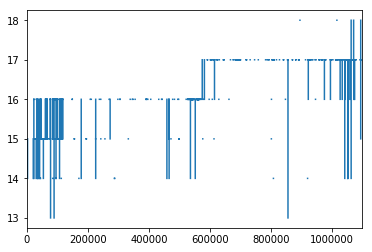

In [45]:
master_df['id_31_edge_version'].plot()

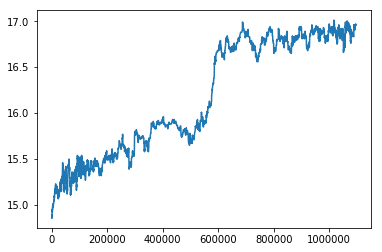

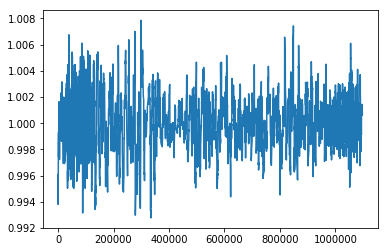

In [46]:
rolling_window = 100
min_rolling_window = 10
temp_df = master_df[['id_31_edge_version']].loc[master_df['id_31_edge_version'].notnull()].astype('float16')
temp_df['id_31_edge_version_newness'] = temp_df['id_31_edge_version'] / temp_df['id_31_edge_version'].rolling(rolling_window, center= True, min_periods=min_rolling_window).mean()
#train_df[new_col_name] = train_df[col] / train_df[col].rolling(rolling_window, center= True, min_periods=min_rolling_window).mean().interpolate()

plt.plot(temp_df['id_31_edge_version'].rolling(rolling_window, center= True, min_periods=min_rolling_window).mean())
plt.show()
plt.plot(temp_df['id_31_edge_version_newness'].rolling(rolling_window, center= True, min_periods=min_rolling_window).mean())

In [47]:
master_df['id_31_edge_version_newness'] = temp_df['id_31_edge_version_newness']
master_df.drop(columns=['id_31_edge_version'], inplace=True)
del temp_df
gc.collect()
cols_cont.add('id_31_edge_version_newness')

In [48]:
master_df.id_31.loc[master_df['id_31_firefox']==True].value_counts()

firefox 57.0           3331
firefox 63.0           1899
firefox 61.0           1321
firefox 64.0           1251
firefox 59.0           1152
firefox 62.0           1107
firefox                 926
firefox 58.0            851
firefox 52.0            621
firefox 60.0            607
firefox 55.0            528
firefox 48.0            254
firefox 56.0            156
firefox generic         110
firefox mobile 61.0     102
firefox mobile 62.0      66
firefox mobile 63.0      55
firefox 47.0             51
mozilla/firefox           5
Name: id_31, dtype: int64

In [49]:
master_df['id_31_firefox_version'] = master_df['id_31'].loc[master_df['id_31_firefox']==True].str.slice(start=-4, stop=-2)
master_df['id_31_firefox_version'].loc[master_df['id_31_firefox_version'] =='ef'] = np.nan
master_df['id_31_firefox_version'].loc[master_df['id_31_firefox_version'] =='er'] = np.nan
#master_df[['id_31', 'id_31_firefox_version']].loc[master_df['id_31_firefox_version'].notnull()].head(20)
master_df['id_31_firefox_version'].value_counts()

57    3331
63    1954
61    1423
64    1251
62    1173
59    1152
58     851
52     621
60     607
55     528
48     254
56     156
47      51
Name: id_31_firefox_version, dtype: int64

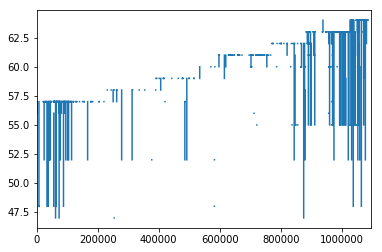

In [50]:
master_df['id_31_firefox_version'].astype('float16').plot()

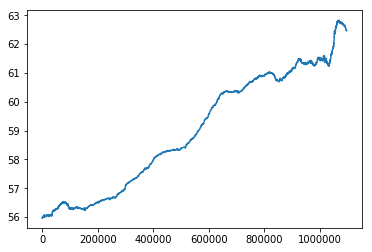

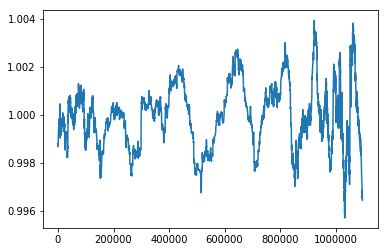

In [51]:
rolling_window = 1000
min_rolling_window = 100
temp_df = master_df[['id_31_firefox_version']].loc[master_df['id_31_firefox_version'].notnull()].astype('float16')
temp_df['id_31_firefox_version_newness'] = temp_df['id_31_firefox_version'] / temp_df['id_31_firefox_version'].rolling(rolling_window, center= True, min_periods=min_rolling_window).mean()
#train_df[new_col_name] = train_df[col] / train_df[col].rolling(rolling_window, center= True, min_periods=min_rolling_window).mean().interpolate()

plt.plot(temp_df['id_31_firefox_version'].rolling(rolling_window, center= True, min_periods=min_rolling_window).mean())
plt.show()
plt.plot(temp_df['id_31_firefox_version_newness'].rolling(rolling_window, center= True, min_periods=min_rolling_window).mean())

In [52]:
master_df['id_31_firefox_version_newness'] = temp_df['id_31_firefox_version_newness']
master_df.drop(columns=['id_31_firefox_version'], inplace=True)
del temp_df
gc.collect()
cols_cont.add('id_31_firefox_version_newness')

That's enough with the id_31 variable (but can do the same for the samsung kind)

In [53]:
# check 'DeviceInfo' variable
master_df['DeviceInfo'].astype(str).value_counts()[0:20]

nan                            863508
Windows                         92710
iOS Device                      38502
MacOS                           23722
Trident/7.0                     12330
rv:11.0                          2650
SM-G532M Build/MMB29T             980
rv:57.0                           968
SM-J700M Build/MMB29K             829
SM-G610M Build/MMB29K             804
SM-G531H Build/LMY48B             682
rv:63.0                           474
ALE-L23 Build/HuaweiALE-L23       458
SM-G935F Build/NRD90M             450
SAMSUNG                           445
rv:61.0                           421
rv:52.0                           378
rv:59.0                           376
rv:62.0                           335
SM-G955U Build/NRD90M             334
Name: DeviceInfo, dtype: int64

No clear FE to do here .... move on

In [54]:
# check 'id_30'
master_df['id_30'].astype(str).value_counts()[0:30]

nan                 949007
Windows 10           42170
Windows 7            23478
iOS 12.1.0            6349
Mac OS X 10_12_6      3884
iOS 11.2.1            3824
Mac OS X 10_11_6      3802
iOS 11.1.2            3776
Android 7.0           3573
iOS 11.4.1            3539
Windows 8.1           3308
Mac OS X 10_13_6      3254
Android 8.0.0         2798
iOS 11.3.0            2662
Mac OS X 10_10_5      2575
Linux                 2488
iOS 10.3.3            2043
Android               1848
iOS 11.2.6            1834
iOS 12.0.1            1691
iOS 11.4.0            1610
Mac OS X 10_13_2      1493
iOS 11.2.5            1373
Mac OS X 10_13_1      1310
iOS 12.0.0            1255
iOS 12.1.2            1208
Mac OS X 10_13_4      1151
Mac OS X 10_14_1      1063
Mac OS X 10_13_3      1043
iOS 11.2.2             954
Name: id_30, dtype: int64

In [55]:
#lowercase the whole column
master_df['id_30'] = master_df['id_30'].loc[master_df['id_30'].notnull()].str.lower()

In [56]:
temp = list(master_df['id_30'].unique())

temp.remove(np.nan)
#print(temp)
new_temp = []
import re
#DATA = "Hey, you - what are you doing here!?"
#print re.findall(r"[\w']+", DATA)
for item in temp:
    #new_temp.extend(item.split())
    new_temp.extend(re.findall(r"[\w']+", item))
new_temp
from collections import Counter
most_common_words= [word for word, word_count in Counter(new_temp).most_common(1000)]

#remove digits
most_common_words= [word for word in most_common_words if not word.isdigit()]

#remove single letter words
most_common_words= [word for word in most_common_words if len(word) > 1]

print(most_common_words)

['mac', 'os', 'ios', 'android', 'windows', '10_11_6', 'linux', '10_7_5', '10_12_6', '10_13_1', '10_9_5', '10_10_5', '10_11_5', 'vista', '10_12_3', '10_12', '10_12_5', '10_8_5', 'xp', '10_6_8', '10_11_4', '10_12_1', '10_11_3', '10_12_4', '10_13_2', '10_12_2', 'func', 'other', '10_13_3', '10_13_4', '10_13_5', '10_13_6', '10_14_0', '10_14', '10_14_1', '10_14_2']


In [57]:
# Hard code most common words
most_common_words = ['mac', 'ios', 'android', 'windows', 'linux']
most_common_words

['mac', 'ios', 'android', 'windows', 'linux']

In [58]:
temp_min_n_in_cat_to_keep = 1000

temp_added_cols = set()

for word in most_common_words:
    temp_len = len(master_df['id_30'].loc[master_df['id_30'].notnull() & master_df['id_30'].str.contains(word)])
    if temp_len >= temp_min_n_in_cat_to_keep:
        print("%s: %d \n" %(word, temp_len))
        temp_new_col_name = 'id_30' + '_' + word 
        master_df[temp_new_col_name] = master_df['id_30'].str.contains(word)
        temp_added_cols.add(temp_new_col_name)
        print(master_df[temp_new_col_name].describe())
        print(80* '-')

mac: 25634 

count     148224
unique         2
top        False
freq      122590
Name: id_30_mac, dtype: object
--------------------------------------------------------------------------------
ios: 38502 

count     148224
unique         2
top        False
freq      109722
Name: id_30_ios, dtype: object
--------------------------------------------------------------------------------
android: 11783 

count     148224
unique         2
top        False
freq      136441
Name: id_30_android, dtype: object
--------------------------------------------------------------------------------
windows: 69777 

count     148224
unique         2
top        False
freq       78447
Name: id_30_windows, dtype: object
--------------------------------------------------------------------------------
linux: 2488 

count     148224
unique         2
top        False
freq      145736
Name: id_30_linux, dtype: object
--------------------------------------------------------------------------------


In [59]:
cols_cat = cols_cat.union(temp_added_cols)
#cols_cat

In [60]:
corr = master_df[temp_added_cols].astype('float16').corr()
corr.style.background_gradient(cmap='coolwarm')

,id_30_windows,id_30_linux,id_30_android,id_30_mac,id_30_ios
id_30_windows,1,-0.123228,-0.277155,-0.431269,-0.55868
id_30_linux,-0.123228,1,-0.038397,-0.0597479,-0.0773992
id_30_android,-0.277155,-0.038397,1,-0.13438,-0.174081
id_30_mac,-0.431269,-0.0597479,-0.13438,1,-0.270879
id_30_ios,-0.55868,-0.0773992,-0.174081,-0.270879,1


enough FE with id_30 (though could code newness like done with 'id_31'

In [61]:
# FE of id_33
master_df['id_33'].loc[master_df['id_33'].notnull()].astype(str).value_counts()[0:30]

1920x1080    33742
1366x768     15046
1334x750     11550
2208x1242     9113
1440x900      8127
1600x900      6603
2048x1536     6556
2436x1125     4230
2560x1600     3871
1280x800      3704
2880x1800     3644
2560x1440     3325
1680x1050     3176
1280x1024     3071
1136x640      2825
1280x720      2407
1024x768      2051
1920x1200     1892
2001x1125     1875
2220x1080     1430
2220x1081     1061
3360x2100      870
5120x2880      866
1366x767       836
2732x2048      791
3840x2160      588
2736x1824      567
2224x1668      551
2688x1242      469
4096x2304      460
Name: id_33, dtype: int64

In [62]:
gc.collect()

64

In [63]:
temp_df = pd.DataFrame()
temp_df[['id_33_1', 'id_33_2']] = master_df['id_33'].loc[master_df['id_33'].notnull()].str.split('x', expand=True)
temp_df = temp_df.astype('float64')
temp_df['id_33_1'].loc[temp_df['id_33_1']==0] = np.nan
temp_df['id_33_2'].loc[temp_df['id_33_2']==0] = np.nan

In [64]:
temp_df['id_33_resolution'] = temp_df['id_33_1'] * temp_df['id_33_2']
temp_df['id_33_resolution'] = np.log(temp_df['id_33_resolution'])
temp_df.describe()

,id_33_1,id_33_2,id_33_resolution
count,143954.000000,143954.000000,143954.000000
mean,1853.111105,1085.736965,14.428717
std,579.631056,349.975140,0.560561
min,455.000000,256.000000,11.665475
25%,1366.000000,768.000000,13.863432
50%,1920.000000,1080.000000,14.544797
75%,2048.000000,1200.000000,14.823651
max,8960.000000,5040.000000,17.625687


In [65]:
master_df['id_33_resolution'] = temp_df['id_33_resolution']
cols_cont.add('id_33_resolution')
del temp_df
gc.collect()

29

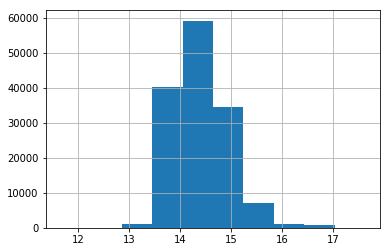

In [66]:
master_df['id_33_resolution'].hist()

Moving now to some FE of continuous variables

In [67]:
# Decimal part of the 'TransactionAmt' feature
master_df['TransactionAmt_decimal'] = ((master_df['TransactionAmt'] - master_df['TransactionAmt'].astype(int)) * 1000).astype(int)
# Length of the 'TransactionAmt' feature
master_df['TransactionAmt_decimal_length'] = master_df['TransactionAmt'].astype(str).str.split('.', expand=True)[1].str.len()

cols_cont.update(['TransactionAmt_decimal', 'TransactionAmt_decimal_length'])

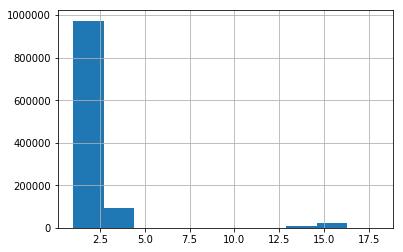

In [68]:
master_df['TransactionAmt_decimal_length'].hist()

In [69]:
gc.collect()

10

In [70]:
## Thanks to FChmiel (https://www.kaggle.com/fchmiel) for these two functions
def make_day_feature(df, offset=0, tname='TransactionDT'):
    """
    Creates a day of the week feature, encoded as 0-6. 
    
    Parameters:
    -----------
    df : pd.DataFrame
        df to manipulate.
    offset : float (default=0)
        offset (in days) to shift the start/end of a day.
    tname : str
        Name of the time column in df.
    """
    # found a good offset is 0.58
    days = df[tname] / (3600*24)        
    encoded_days = np.floor(days-1+offset) % 7
    return encoded_days

def make_hour_feature(df, tname='TransactionDT'):
    """
    Creates an hour of the day feature, encoded as 0-23. 
    
    Parameters:
    -----------
    df : pd.DataFrame
        df to manipulate.
    tname : str
        Name of the time column in df.
    """
    hours = df[tname] / (3600)        
    encoded_hours = np.floor(hours) % 24
    return encoded_hours

In [71]:
master_df['weekday'] = make_day_feature(master_df, offset=0.58)
master_df['hours'] = make_hour_feature(master_df)
                                     
cols_cat.update(['weekday', 'hours'])

In [72]:
# check all cols in either cols_cat or cols_cont
print(set(master_df.columns).difference(cols_cat.union(cols_cont)))
print(cols_cat.intersection(cols_cont))

{'isFraud'}
set()


In [73]:
master_df.memory_usage().sum()

3864712533

In [74]:
temp_cols_cat_list = list(cols_cat)
master_df[temp_cols_cat_list] = master_df[temp_cols_cat_list].astype('category')
gc.collect()
master_df[cols_cat].describe()

,id_14,card2,M9,M4,id_31_application,id_31_chrome,ProductCD,id_31_samsung,card1,id_29,M8,id_28,id_15,addr2,id_35,M5,DeviceInfo,R_emaildomain_3,R_emaildomain_4,R_emaildomain,id_31_ios,id_31_for,M3,id_30_windows,id_31_mobile,P_emaildomain_3,id_31_desktop,id_31_search,hours,id_30_mac,id_31_browser,id_13,M6,addr1,id_24,card3,id_17,id_31_firefox,id_31_safari,id_25,R_emaildomain_2,id_22,id_34,id_26,id_30_linux,id_31_generic,weekday,id_31_ie,id_33,id_31_edge,id_23,id_30_ios,card6,id_31_tablet,P_emaildomain,DeviceType,id_32,M1,id_31_google,card4,id_36,id_38,id_27,id_31,id_18,id_20,R_emaildomain_1,id_37,M7,id_30_android,id_19,id_30,id_21,M2,id_16,P_emaildomain_1,P_emaildomain_4,id_31_android,id_12,P_emaildomain_2,card5
count,151401.0,1079644.0,515975,578042,276907,276907,1097231,276907,1097231,277756,515975,277756,277962,965916.0,277962,437117,233723,5084,273161,273161,276907,276907,649492,148224,276907,5733,276907,276907,1097231.0,148224,276907,257606.0,768932,965916.0,9487.0,1092664.0,275335.0,276907,276907,10171.0,272965,10231.0,149980,10210.0,148224,276907,1097231.0,276907,143960,276907,10231,148224,1092653,276907,933583,277741,148257.0,649492,276907,1092568,277962,277962,10231,276907,95988.0,274894.0,273161,277962,515948,148224,275224.0,148224,10218.0,649492,255087,933583,933583,276907,286140,932590,1088425.0
unique,28.0,501.0,2,3,2,2,5,2,17091,2,2,2,3,93.0,2,2,2799,4,12,60,2,2,2,2,2,4,2,2,24.0,2,2,55.0,2,441.0,17.0,133.0,127.0,2,2,440.0,8,35.0,4,115.0,2,2,7.0,2,461,2,3,2,4,2,60,2,6.0,2,2,4,2,2,2,172,19.0,547.0,45,2,2,2,568.0,87,734.0,2,2,45,12,2,2,8,138.0
top,-300.0,321.0,T,M0,False,True,W,False,7919,Found,F,Found,Found,87.0,T,F,Windows,mx,com,gmail.com,False,False,T,False,False,mx,False,False,19.0,False,False,52.0,F,299.0,11.0,150.0,166.0,False,False,321.0,com,14.0,match_status:2,161.0,False,False,1.0,False,1920x1080,False,IP_PROXY:TRANSPARENT,False,debit,False,gmail.com,desktop,24.0,T,False,visa,F,F,Found,mobile safari 11.0,15.0,507.0,gmail,T,F,False,266.0,windows 10,252.0,T,Found,gmail,com,False,NotFound,com,226.0
freq,83733.0,91731.0,441935,357789,275060,155502,800657,272120,28015,149264,323650,151813,135690,956415.0,149464,240155,92710,4510,254533,118885,274292,208954,518244,78447,223425,4600,262704,275060,77870.0,122590,272122,109760.0,419433,85045.0,5666.0,956845.0,150938.0,262514,207041,5233.0,258740,9487.0,132185,1576.0,145736,250766,180082.0,260438,33742,264922,7203,109722,824959,275577,435803,159568,104040.0,649436,274761,719649,267353,168980,10214,23655,53476.0,34192.0,119081,215149,444604,136441,39541.0,42170,3552.0,588323,132805,436796,877106,225913,243920,881403,553537.0


In [75]:
master_df.memory_usage().sum()

3604687122

In [76]:
master_df.drop(columns = ['id_30', 'id_31', 'id_33'], inplace = True)
cols_cat.remove('id_30')
cols_cat.remove('id_31')
cols_cat.remove('id_33')

In [77]:
cols_cat_dummified = set()
n_categories_to_keep = 24

for col in cols_cat:
    print("%s, " %col, end="")
    
    len_categories = len(master_df[col].loc[master_df[col].notnull()].unique())
    temp_col = master_df.loc[:, [col]]
    
    if n_categories_to_keep < len_categories:
        top_cats = list(temp_col[col].value_counts(ascending = False, normalize=False).iloc[:n_categories_to_keep].index) 
        temp_col[col].cat.add_categories(['infrequent_category'], inplace = True)
        top_cats.append('infrequent_category')
        #print(list(top_cats))
        temp_col.loc[temp_col[col].notnull() & ~temp_col[col].isin(top_cats), [col]] = 'infrequent_category'
        temp_col[col].cat.remove_categories([cat for cat in temp_col[col].cat.categories if not cat in top_cats], inplace = True)
    
    temp_col = pd.get_dummies(temp_col, dummy_na=True)
    
    cols_cat_dummified.update(list(temp_col.columns))
    master_df[temp_col.columns] = temp_col
    
    del temp_col
    gc.collect()

id_14, card2, M9, M4, id_31_application, id_31_chrome, ProductCD, id_31_samsung, card1, id_29, M8, id_28, id_15, addr2, id_35, M5, DeviceInfo, R_emaildomain_3, R_emaildomain_4, R_emaildomain, id_31_ios, id_31_for, M3, id_30_windows, id_31_mobile, P_emaildomain_3, id_31_desktop, id_31_search, hours, id_30_mac, id_31_browser, id_13, M6, addr1, id_24, card3, id_17, id_31_firefox, id_31_safari, id_25, R_emaildomain_2, id_22, id_34, id_26, id_30_linux, id_31_generic, weekday, id_31_ie, id_31_edge, id_23, id_30_ios, card6, id_31_tablet, P_emaildomain, DeviceType, id_32, M1, id_31_google, card4, id_36, id_38, id_27, id_18, id_20, R_emaildomain_1, id_37, M7, id_30_android, id_19, id_21, M2, id_16, P_emaildomain_1, P_emaildomain_4, id_31_android, id_12, P_emaildomain_2, card5, 

In [78]:
master_df[cols_cat_dummified].astype('category').describe()

,id_22_infrequent_category,P_emaildomain_4_com.mx,id_20_600.0,R_emaildomain_icloud.com,card5_219.0,ProductCD_C,P_emaildomain_optonline.net,card5_102.0,id_31_chrome_False,id_25_486.0,R_emaildomain_1_yahoo,addr1_231.0,id_14_nan,DeviceInfo_rv:62.0,id_18_23.0,P_emaildomain_att.net,id_22_31.0,addr1_264.0,id_24_16.0,id_19_529.0,card5_100.0,R_emaildomain_ymail.com,R_emaildomain_hotmail.com,id_19_153.0,id_31_firefox_True,addr1_327.0,R_emaildomain_1_ymail,id_13_43.0,P_emaildomain_1_yahoo,id_31_generic_nan,M7_T,id_19_317.0,id_26_117.0,hours_23.0,R_emaildomain_1_nan,hours_18.0,card3_229.0,weekday_nan,id_19_321.0,id_30_mac_nan,card5_138.0,id_24_18.0,card2_553.0,M1_nan,id_35_T,id_32_nan,hours_4.0,id_17_191.0,id_34_match_status:-1,id_18_10.0,card5_162.0,id_24_15.0,id_31_generic_False,P_emaildomain_1_me,M4_nan,id_21_nan,R_emaildomain_1_mac,card1_15885,card1_4461,id_20_325.0,card2_476.0,card3_100.0,card3_213.0,R_emaildomain_outlook.com,P_emaildomain_4_com,R_emaildomain_4_fr,P_emaildomain_1_infrequent_category,addr2_29.0,id_14_-300.0,id_30_linux_True,M1_F,card2_399.0,card5_infrequent_category,id_22_28.0,P_emaildomain_2_de,card1_5812,id_25_505.0,id_20_401.0,addr1_126.0,id_17_146.0,id_25_442.0,id_13_63.0,card2_111.0,id_18_13.0,id_20_535.0,id_14_180.0,id_14_-600.0,id_28_nan,id_22_26.0,R_emaildomain_4_co.jp,card3_nan,id_31_for_False,id_20_597.0,id_19_542.0,M4_M2,P_emaildomain_2_fr,card2_268.0,hours_16.0,id_26_163.0,id_20_256.0,R_emaildomain_yahoo.com,addr1_441.0,id_21_228.0,card3_197.0,id_14_infrequent_category,id_19_352.0,card2_512.0,id_31_application_True,card3_146.0,id_20_333.0,card5_nan,id_25_321.0,R_emaildomain_3_mx,R_emaildomain_1_mail,card2_555.0,R_emaildomain_2_com,addr2_65.0,addr2_73.0,id_25_479.0,id_22_21.0,id_25_infrequent_category,id_14_-240.0,R_emaildomain_web.de,id_25_463.0,hours_14.0,id_14_60.0,R_emaildomain_bellsouth.net,P_emaildomain_4_net.mx,P_emaildomain_3_com,id_24_12.0,P_emaildomain_2_es,id_22_16.0,card6_debit,R_emaildomain_4_de,id_30_mac_False,DeviceInfo_Trident/7.0,id_26_194.0,id_35_nan,P_emaildomain_4_rr.com,id_20_222.0,id_13_55.0,id_26_162.0,id_20_127.0,addr1_433.0,id_31_ie_True,addr2_60.0,id_17_nan,id_19_176.0,id_31_edge_True,card2_375.0,card3_106.0,P_emaildomain_4_de,card5_195.0,id_26_215.0,card1_nan,id_18_27.0,P_emaildomain_2_edu,P_emaildomain_rocketmail.com,hours_20.0,id_26_143.0,R_emaildomain_cox.net,R_emaildomain_1_cox,addr2_102.0,P_emaildomain_4_nan,addr2_59.0,DeviceInfo_rv:52.0,M5_F,id_24_14.0,card3_185.0,addr1_485.0,id_26_121.0,id_17_100.0,id_34_nan,id_13_19.0,P_emaildomain_4_co.uk,weekday_3.0,id_27_NotFound,weekday_0.0,id_21_770.0,id_30_windows_False,addr1_310.0,id_31_tablet_False,M3_T,id_24_10.0,card2_361.0,id_22_13.0,card6_charge card,R_emaildomain_comcast.net,card5_137.0,card5_197.0,card1_7585,DeviceInfo_SM-G935F Build/NRD90M,id_18_24.0,card5_185.0,id_13_28.0,DeviceInfo_rv:63.0,id_17_143.0,P_emaildomain_nan,id_25_247.0,weekday_4.0,id_21_262.0,R_emaildomain_anonymous.com,id_24_24.0,id_31_edge_False,P_emaildomain_verizon.net,id_14_-480.0,weekday_5.0,card1_15497,id_19_492.0,id_17_102.0,id_31_samsung_False,addr2_87.0,id_31_browser_False,DeviceInfo_SM-J700M Build/MMB29K,id_18_20.0,id_19_271.0,id_18_nan,id_13_61.0,card4_visa,DeviceInfo_SM-G532M Build/MMB29T,id_17_212.0,id_22_20.0,hours_17.0,id_31_ie_False,id_22_39.0,id_30_android_False,card4_nan,R_emaildomain_3_uk,addr1_191.0,id_18_19.0,id_17_135.0,R_emaildomain_1_gmx,hours_2.0,id_21_252.0,id_20_489.0,id_19_215.0,id_13_14.0,id_30_ios_nan,id_29_Found,id_31_application_nan,M7_F,P_emaildomain_hotmail.com,R_emaildomain_1_icloud,id_31_mobile_True,id_26_137.0,R_emaildomain_4_edu,card3_147.0,id_24_20.0,P_emaildomain_1_netzero,card2_infrequent_category,...,id_20_612.0,R_emaildomain_1_comcast,R_emaildomain_1_hotmail,P_emaildomain_1_gmail,addr2_72.0,id_25_426.0,id_31_application_False,id_14_-360.0,id_36_T,id_13_54.0,id_22_43.0,addr2_19.0,id_31_tablet_nan,hours_0.0,id_30_ios_False,card6_credit,id_24_21.0,id_25_359.0,id_13_20.0,id_14_240.0,card2_100.0,P_emaildomain_1_comcast,ho

In [79]:
master_df.shape

(1097231, 1276)

In [80]:
for col in cols_cat:
    master_df[col] = master_df[col].astype('category').cat.codes

(6666, 1273)
(3334, 1273)
roc_auc score 0.8986


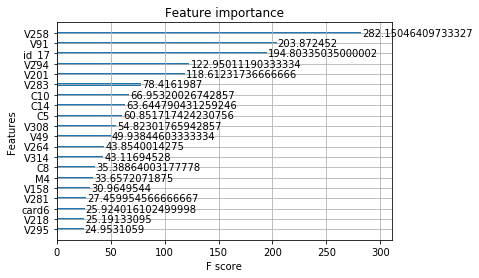

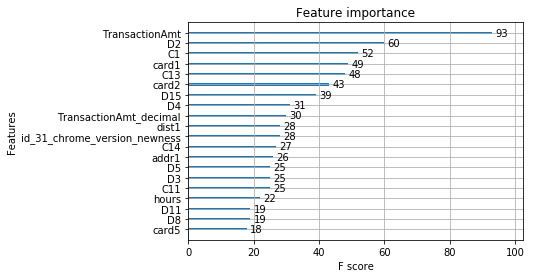

In [81]:
length_ones = len(master_df[master_df['isFraud']==1])
train_balanced = pd.concat([master_df[master_df['isFraud']==1], (master_df[master_df['isFraud']==0]).sample(length_ones)], axis=0)

#train_balanced = train_df.sample(40000)
#rand_cols = set(random.sample(list(train_df.columns), 200))
#rand_cols = list(rand_cols.union({'isFraud', 'TransactionID', 'TransactionDT'}))
#train_balanced = train_df.loc[:, rand_cols].sample(100000)
#train_balanced = train_balanced.loc[:, rand_cols]
#train_balanced = train_balanced.iloc[:, 0:600]

#train_balanced = train_balanced.loc[:, list(cols_cont) + ['isFraud']]

train_balanced = train_balanced.sample(10000)

#train_balanced.drop(columns= list(cols_cat), inplace=True)

#added_list = ['isFraud', 'TransactionID', 'TransactionDT', 'TransactionAmt']
#cols_cat_dummified.update(added_list)
#train_balanced = train_balanced.loc[:, list(cols_cat_dummified)]

X_train, X_test, y_train, y_test = train_test_split(
    train_balanced.drop(columns=['isFraud', 'TransactionID', 'TransactionDT']), train_balanced['isFraud'], 
    test_size=1/3, stratify =train_balanced['isFraud'],  random_state=0)

'''
temp_q1_len = int(len(train_df) / 4) 
temp_half_len = int(len(train_df) / 2)
temp_q3_len = int(len(train_df) / 4) + temp_half_len

X_train = train_df.drop(columns=['isFraud', 'TransactionID', 'TransactionDT']).loc[:temp_q1_len ]
y_train = train_df.loc[:temp_q1_len, 'isFraud']
X_test = train_df.drop(columns=['isFraud', 'TransactionID', 'TransactionDT']).loc[temp_q3_len: ]
y_test = train_df.loc[temp_q3_len:, 'isFraud']
'''

print(X_train.shape)
print(X_test.shape)

clf = XGBClassifier(max_depth=5)
clf.fit(X_train, y_train)
pred_prob = clf.predict_proba(X_test)
pred_prob[:, 1]
roc_score = roc_auc_score(y_test, pred_prob[:, 1])
print("roc_auc score %.4f" % roc_score)
xgboost.plot_importance(clf, max_num_features=20, importance_type='gain')
xgboost.plot_importance(clf, max_num_features=20, importance_type='weight')
#cols_cat_dummified.difference_update(set(added_list))

In [82]:
temp = clf.get_booster().get_score(importance_type='gain')
df = pd.DataFrame(temp.keys(), columns=['Feature'])
df['Feature_importance'] = temp.values()
df = df.sort_values(by=['Feature_importance'], ascending = False)
print(df.shape)
df

(325, 2)


,Feature,Feature_importance
0,V258,282.150464
54,V91,203.872452
65,id_17,194.803350
1,V294,122.950112
91,V201,118.612317
...,...,...
303,P_emaildomain_gmail.com,0.165094
234,addr1_441.0,0.107167
321,V278,0.086703
214,V184,0.077841


In [83]:
temp_list = df.Feature.index
#print(temp_list)
df.loc[[index for index in temp_list if df.Feature[index] in cols_cat_dummified], :]

,Feature,Feature_importance
93,card6_credit,23.996873
66,R_emaildomain_4_com,18.100857
23,card2_321.0,17.864010
153,R_emaildomain_gmail.com,16.877221
172,id_32_24.0,16.723550
...,...,...
164,id_13_43.0,1.375702
230,hours_15.0,0.793003
213,id_19_290.0,0.276938
303,P_emaildomain_gmail.com,0.165094


In [84]:
del X_train, X_test, y_train, y_test 
gc.collect()

4718

(6666, 325)
(3334, 325)
roc_auc score 0.8926


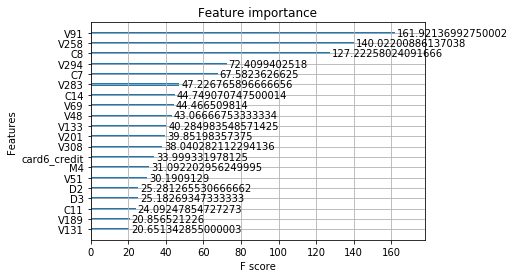

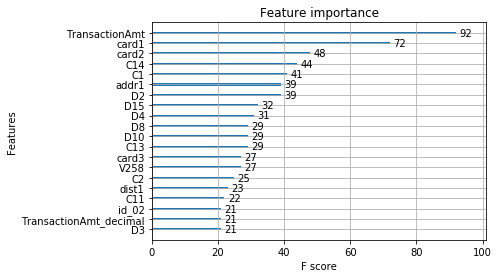

In [85]:
length_ones = len(master_df[master_df['isFraud']==1])
train_balanced = pd.concat([master_df[master_df['isFraud']==1], (master_df[master_df['isFraud']==0]).sample(length_ones)], axis=0)

train_balanced = train_balanced.sample(10000)

#train_balanced.drop(columns= list(cols_cat), inplace=True)

X_train, X_test, y_train, y_test = train_test_split(
    train_balanced.loc[:, list(df['Feature'])], train_balanced['isFraud'], 
    test_size=1/3, stratify =train_balanced['isFraud'],  random_state=0)

print(X_train.shape)
print(X_test.shape)

clf = XGBClassifier(max_depth=5)
clf.fit(X_train, y_train)
pred_prob = clf.predict_proba(X_test)
pred_prob[:, 1]
roc_score = roc_auc_score(y_test, pred_prob[:, 1])
print("roc_auc score %.4f" % roc_score)
xgboost.plot_importance(clf, max_num_features=20, importance_type='gain')
xgboost.plot_importance(clf, max_num_features=20, importance_type='weight')
#cols_cat_dummified.difference_update(set(added_list))

In [86]:
temp = clf.get_booster().get_score(importance_type='gain')
df = pd.DataFrame(temp.keys(), columns=['Feature'])
df['Feature_importance'] = temp.values()
df = df.sort_values(by=['Feature_importance'], ascending = False)
print(df.shape)
df

(245, 2)


,Feature,Feature_importance
1,V91,161.921370
0,V258,140.022009
5,C8,127.222580
2,V294,72.409940
25,C7,67.582363
...,...,...
206,V144,0.626113
194,V164,0.528626
179,hours_3.0,0.320995
58,V318,0.061021


In [87]:
temp_list = df.Feature.index
#print(temp_list)
df.loc[[index for index in temp_list if df.Feature[index] in cols_cat_dummified], :]

,Feature,Feature_importance
36,card6_credit,33.999332
163,card3_185.0,19.976559
118,DeviceInfo_Windows,18.106239
117,R_emaildomain_gmail.com,15.334688
13,card2_321.0,14.778191
22,M5_F,11.438295
137,ProductCD_R,11.372190
168,card5_226.0,10.055281
129,card2_555.0,8.912813
213,id_32_24.0,8.347672


In [88]:
del X_train, X_test, y_train, y_test 
gc.collect()

4866

In [89]:
temp_list = [col for col in master_df.columns if ('addr' in col or 'card' in col or 'hour' in col or 'week' in col) and '_' in col ]
#print(temp_list)

(6666, 1274)
(3334, 1274)
[03:02:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
R2 score 0.2060


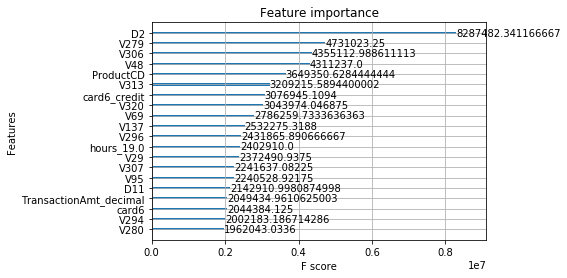

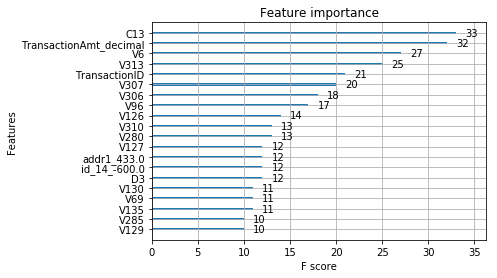

In [90]:
clf = XGBRegressor(max_depth=3, eta = 0.01)

rand_sample_indeces = master_df.sample(10000).index

temp_list_to_drop = []
#temp_list_to_drop = list(cols_cat)
#temp_list_to_drop.extend(['isFraud', 'TransactionID', 'TransactionDT', 'TransactionAmt'])
temp_list_to_drop.extend(['isFraud',  'TransactionAmt'])
#print(temp_list_to_drop)

#X_train, X_test, y_train, y_test = train_test_split(master_df.iloc[rand_sample_indeces].drop(columns= temp_list_to_drop), 
#                                                    master_df.loc[rand_sample_indeces, 'TransactionAmt'], 
#                                                    test_size=1/3,  random_state=0)

X_train, X_test, y_train, y_test = train_test_split(master_df.loc[rand_sample_indeces].drop(columns= temp_list_to_drop), 
                                                    master_df.loc[rand_sample_indeces, 'TransactionAmt'], 
                                                    test_size=1/3,  random_state=0)

print(X_train.shape)
print(X_test.shape)

clf.fit(X_train, y_train)
pred_y = clf.predict(X_test)
r2Score = r2_score(y_test, pred_y)
print("R2 score %.4f" % r2Score)

xgboost.plot_importance(clf, max_num_features=20, importance_type='gain')
xgboost.plot_importance(clf, max_num_features=20, importance_type='weight')

In [91]:
del X_train, X_test, y_train, y_test 
gc.collect()

4595

In [92]:
len(master_df)

1097231

In [93]:
master_df['TransactionAmt_to_predicted'] = np.nan
temp_list_to_drop.append('TransactionAmt_to_predicted')
len_master_df = len(master_df)
counter_from = 0
while counter_from < len_master_df:
    print(counter_from)
    counter_to = counter_from + 40000
    pred_y = clf.predict(master_df.iloc[counter_from:counter_to].drop(columns= temp_list_to_drop))
    master_df.loc[counter_from:counter_to, ['TransactionAmt_to_predicted']] = master_df['TransactionAmt'].iloc[counter_from:counter_to] - pred_y
    counter_from += 40000
    gc.collect()

0
40000
80000
120000
160000
200000
240000
280000
320000
360000
400000
440000
480000
520000
560000
600000
640000
680000
720000
760000
800000
840000
880000
920000
960000
1000000
1040000
1080000


In [94]:
master_df['TransactionAmt_to_predicted'].describe()

count    1.097231e+06
mean    -6.841709e-01
std      2.013343e+02
min     -2.119790e+03
25%     -6.127291e+01
50%     -2.355669e+01
75%      1.647189e+01
max      3.068637e+04
Name: TransactionAmt_to_predicted, dtype: float64

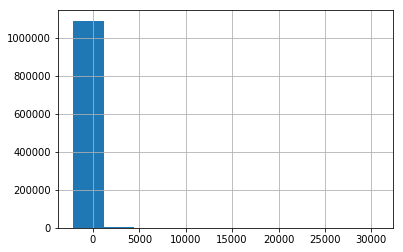

In [95]:
master_df['TransactionAmt_to_predicted'].hist()

(6666, 1274)
(3334, 1274)
roc_auc score 0.8957


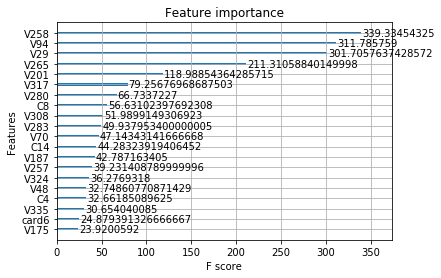

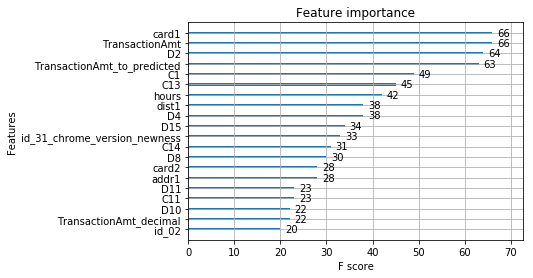

In [96]:
length_ones = len(master_df[master_df['isFraud']==1])
train_balanced = pd.concat([master_df[master_df['isFraud']==1], (master_df[master_df['isFraud']==0]).sample(length_ones)], axis=0)

train_balanced = train_balanced.sample(10000)

#train_balanced.drop(columns= list(cols_cat), inplace=True)


X_train, X_test, y_train, y_test = train_test_split(
    train_balanced.drop(columns=['isFraud', 'TransactionID', 'TransactionDT']), train_balanced['isFraud'], 
    test_size=1/3, stratify =train_balanced['isFraud'],  random_state=0)



print(X_train.shape)
print(X_test.shape)

clf = XGBClassifier(max_depth=5)
clf.fit(X_train, y_train)
pred_prob = clf.predict_proba(X_test)
pred_prob[:, 1]
roc_score = roc_auc_score(y_test, pred_prob[:, 1])
print("roc_auc score %.4f" % roc_score)
xgboost.plot_importance(clf, max_num_features=20, importance_type='gain')
xgboost.plot_importance(clf, max_num_features=20, importance_type='weight')
#cols_cat_dummified.difference_update(set(added_list))

In [97]:
del X_train, X_test, y_train, y_test 
gc.collect()

4776

(20000, 1275)
(10000, 1275)
[03:04:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
R2 score 0.4183


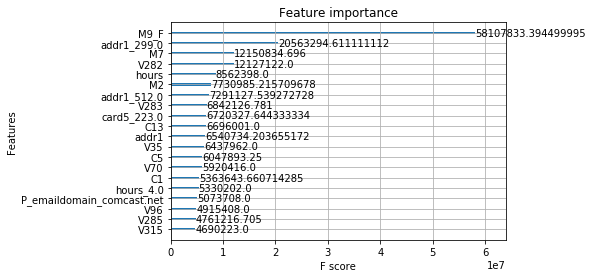

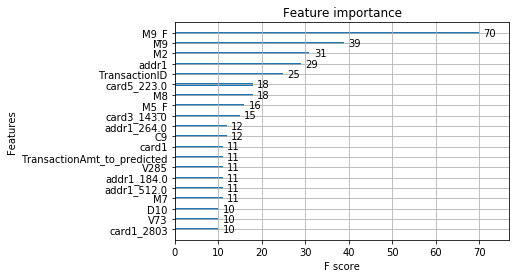

In [98]:
clf = XGBRegressor(max_depth=3, eta= 0.01)

rand_sample_indeces = master_df[master_df['dist1'].notnull()].sample(30000).index

temp_list_to_drop = []
#temp_list_to_drop = list(cols_cat)
#temp_list_to_drop.extend(['isFraud', 'TransactionID', 'TransactionDT', 'dist1'])
temp_list_to_drop.extend(['isFraud', 'dist1'])
#print(temp_list_to_drop)

#X_train, X_test, y_train, y_test = train_test_split(master_df.iloc[rand_sample_indeces].drop(columns= temp_list_to_drop), 
#                                                    master_df.loc[rand_sample_indeces, 'TransactionAmt'], 
#                                                    test_size=1/3,  random_state=0)

X_train, X_test, y_train, y_test = train_test_split(master_df.loc[rand_sample_indeces].drop(columns= temp_list_to_drop), 
                                                    master_df.loc[rand_sample_indeces, 'dist1'], 
                                                    test_size=1/3,  random_state=0)

print(X_train.shape)
print(X_test.shape)

clf.fit(X_train, y_train)
pred_y = clf.predict(X_test)
r2Score = r2_score(y_test, pred_y)
print("R2 score %.4f" % r2Score)

xgboost.plot_importance(clf, max_num_features=20, importance_type='gain')
xgboost.plot_importance(clf, max_num_features=20, importance_type='weight')

In [99]:
del X_train, X_test, y_train, y_test 
gc.collect()

4700

In [100]:
master_df['dist1_to_predicted'] = np.nan
temp_list_to_drop.append('dist1_to_predicted')
len_master_df = len(master_df)
counter_from = 0
while counter_from < len_master_df:
    print(counter_from)
    counter_to = counter_from + 40000
    pred_y = clf.predict(master_df.iloc[counter_from:counter_to].drop(columns= temp_list_to_drop))
    master_df.loc[counter_from:counter_to, ['dist1_to_predicted']] = master_df['dist1'].iloc[counter_from:counter_to] - pred_y
    counter_from += 40000
    gc.collect()

0
40000
80000
120000
160000
200000
240000
280000
320000
360000
400000
440000
480000
520000
560000
600000
640000
680000
720000
760000
800000
840000
880000
920000
960000
1000000
1040000
1080000


In [101]:
master_df[['dist1', 'dist1_to_predicted']].describe()

,dist1,dist1_to_predicted
count,453743.000000,453743.000000
mean,103.573384,-0.497207
std,346.012876,261.207446
min,0.000000,-2853.808350
25%,3.000000,-43.426037
50%,8.000000,-8.192673
75%,22.000000,6.786994
max,10286.000000,8837.853271


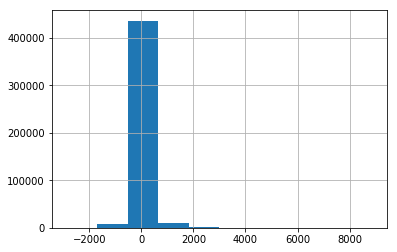

In [102]:
master_df['dist1_to_predicted'].hist()

(6666, 1275)
(3334, 1275)
roc_auc score 0.9020


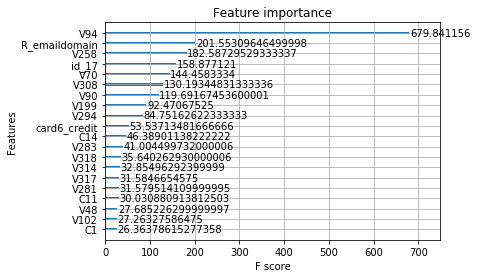

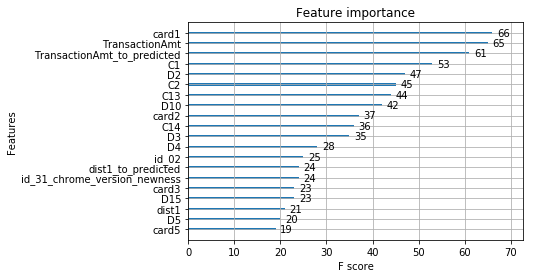

In [103]:
length_ones = len(master_df[master_df['isFraud']==1])
train_balanced = pd.concat([master_df[master_df['isFraud']==1], (master_df[master_df['isFraud']==0]).sample(length_ones)], axis=0)

train_balanced = train_balanced.sample(10000)

#train_balanced.drop(columns= list(cols_cat), inplace=True)


X_train, X_test, y_train, y_test = train_test_split(
    train_balanced.drop(columns=['isFraud', 'TransactionID', 'TransactionDT']), train_balanced['isFraud'], 
    test_size=1/3, stratify =train_balanced['isFraud'],  random_state=0)



print(X_train.shape)
print(X_test.shape)

clf = XGBClassifier(max_depth=5)
clf.fit(X_train, y_train)
pred_prob = clf.predict_proba(X_test)
pred_prob[:, 1]
roc_score = roc_auc_score(y_test, pred_prob[:, 1])
print("roc_auc score %.4f" % roc_score)
xgboost.plot_importance(clf, max_num_features=20, importance_type='gain')
xgboost.plot_importance(clf, max_num_features=20, importance_type='weight')
#cols_cat_dummified.difference_update(set(added_list))

In [104]:
del  X_test, X_train, y_test, y_train
gc.collect()

4779

In [105]:
master_df[['TransactionAmt', 'addr2']].groupby('addr2').mean()

,TransactionAmt
addr2,
-1,41.378668
0,127.272727
1,30.000000
2,100.000000
3,38.825625
...,...
88,59.615308
89,71.132000
90,78.571429


In [106]:
gc.collect()
temp_df_1 = master_df[['TransactionAmt', 'addr2']]
temp_df_2 = master_df[['TransactionAmt', 'addr2']].groupby('addr2').mean()
temp_df_2.rename(columns={"TransactionAmt": "TransactionAmt_by_addr2_mean"}, inplace = True)
temp_df_1 = pd.merge(temp_df_1, temp_df_2, on='addr2', how='left')
master_df['TransactionAmt_by_addr2_mean'] = temp_df_1['TransactionAmt_by_addr2_mean']
master_df['TransactionAmt_to_TransactionAmt_by_addr2_mean'] = master_df['TransactionAmt'] / temp_df_1['TransactionAmt_by_addr2_mean']

In [107]:
del temp_df_1, temp_df_2
gc.collect()

13

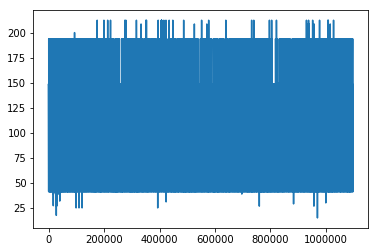

In [108]:
plt.plot(master_df['TransactionAmt_by_addr2_mean'])

(27550, 1277)
(13776, 1277)
roc_auc score 0.9442


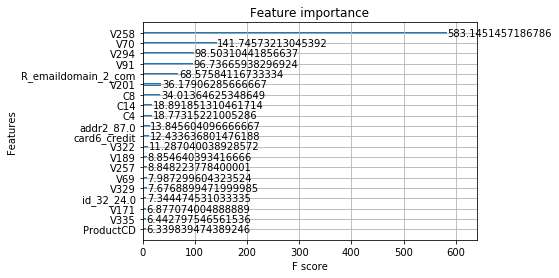

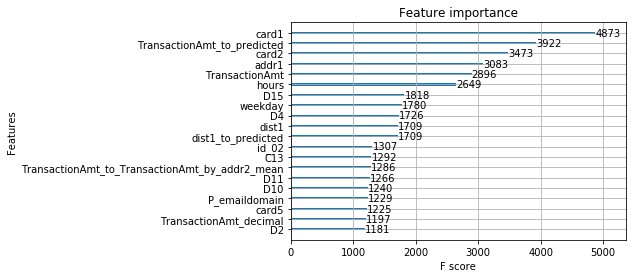

In [109]:
length_ones = len(master_df[master_df['isFraud']==1])
train_balanced = pd.concat([master_df[master_df['isFraud']==1], (master_df[master_df['isFraud']==0]).sample(length_ones)], axis=0)

X_train, X_test, y_train, y_test = train_test_split(
    train_balanced.drop(columns=['isFraud', 'TransactionID', 'TransactionDT']), train_balanced['isFraud'], 
    test_size=1/3, stratify =train_balanced['isFraud'],  random_state=0)



print(X_train.shape)
print(X_test.shape)

clf = XGBClassifier(max_depth=40)
clf.fit(X_train, y_train)
pred_prob = clf.predict_proba(X_test)
pred_prob[:, 1]
roc_score = roc_auc_score(y_test, pred_prob[:, 1])
print("roc_auc score %.4f" % roc_score)
xgboost.plot_importance(clf, max_num_features=20, importance_type='gain')
xgboost.plot_importance(clf, max_num_features=20, importance_type='weight')
#cols_cat_dummified.difference_update(set(added_list))

In [110]:
temp = clf.get_booster().get_score(importance_type='gain')
df = pd.DataFrame(temp.keys(), columns=['Feature'])
df['Feature_importance'] = temp.values()
df = df.sort_values(by=['Feature_importance'], ascending = False)
print(df.shape)
df

(686, 2)


,Feature,Feature_importance
0,V258,583.145146
131,V70,141.745732
1,V294,98.503104
205,V91,96.736659
3,R_emaildomain_2_com,68.575841
...,...,...
669,V302,0.098745
422,id_13_25.0,0.095901
597,id_19_633.0,0.044922
378,id_19_100.0,0.038612


In [111]:
df['Feature'][0:100]

0                     V258
131                    V70
1                     V294
205                    V91
3      R_emaildomain_2_com
              ...         
569                   V157
133             card1_9633
633                   V248
274             DeviceType
337            card1_12695
Name: Feature, Length: 100, dtype: object

In [112]:
temp_list_to_keep = ['isFraud', 'TransactionID', 'TransactionDT', 'is_train_df']
temp_list_to_keep.extend(df['Feature'][0:200])
temp_list_to_drop = [x for x in list(master_df.columns) if x not in temp_list_to_keep]

In [113]:
print(len(temp_list_to_keep))
print(temp_list_to_keep)
print(len(temp_list_to_drop))
print(temp_list_to_drop)


204
['isFraud', 'TransactionID', 'TransactionDT', 'is_train_df', 'V258', 'V70', 'V294', 'V91', 'R_emaildomain_2_com', 'V201', 'C8', 'C14', 'C4', 'addr2_87.0', 'card6_credit', 'V322', 'V189', 'V257', 'V69', 'V329', 'id_32_24.0', 'V171', 'V335', 'ProductCD', 'V187', 'P_emaildomain_cox.net', 'V334', 'V296', 'P_emaildomain_msn.com', 'ProductCD_S', 'D2', 'V244', 'V173', 'V324', 'V249', 'V170', 'P_emaildomain_optonline.net', 'V200', 'C1', 'card2_583.0', 'V243', 'V312', 'V22', 'P_emaildomain_live.com', 'V236', 'V131', 'V289', 'V213', 'V315', 'V285', 'C5', 'addr1_337.0', 'addr1_512.0', 'V138', 'C11', 'card1_9500', 'id_17_100.0', 'ProductCD_R', 'V252', 'V56', 'V105', 'addr1_231.0', 'V30', 'V278', 'V15', 'id_17_166.0', 'V79', 'P_emaildomain_me.com', 'V318', 'card3_185.0', 'addr1_485.0', 'V115', 'V281', 'V17', 'V268', 'M4', 'id_20_368.0', 'id_31_desktop', 'card5_166.0', 'V96', 'V253', 'ProductCD_H', 'V172', 'card2_481.0', 'V137', 'V320', 'V270', 'V223', 'card3_106.0', 'V103', 'V298', 'V145', 'V20

In [114]:
temp = clf.get_booster().get_score(importance_type='weight')
df = pd.DataFrame(temp.keys(), columns=['Feature'])
df['Feature_importance'] = temp.values()
df = df.sort_values(by=['Feature_importance'], ascending = False)
print(df.shape)
df

(686, 2)


,Feature,Feature_importance
18,card1,4873
6,TransactionAmt_to_predicted,3922
7,card2,3473
29,addr1,3083
16,TransactionAmt,2896
...,...,...
632,id_19_390.0,1
635,R_emaildomain_3_mx,1
645,V163,1
648,card1_4461,1


In [115]:
temp_list_to_keep.extend(df['Feature'][0:200])
temp_list_to_drop = [x for x in list(master_df.columns) if x not in temp_list_to_keep]

In [116]:
print(len(temp_list_to_keep))
print(temp_list_to_keep)
print(len(temp_list_to_drop))
print(temp_list_to_drop)


404
['isFraud', 'TransactionID', 'TransactionDT', 'is_train_df', 'V258', 'V70', 'V294', 'V91', 'R_emaildomain_2_com', 'V201', 'C8', 'C14', 'C4', 'addr2_87.0', 'card6_credit', 'V322', 'V189', 'V257', 'V69', 'V329', 'id_32_24.0', 'V171', 'V335', 'ProductCD', 'V187', 'P_emaildomain_cox.net', 'V334', 'V296', 'P_emaildomain_msn.com', 'ProductCD_S', 'D2', 'V244', 'V173', 'V324', 'V249', 'V170', 'P_emaildomain_optonline.net', 'V200', 'C1', 'card2_583.0', 'V243', 'V312', 'V22', 'P_emaildomain_live.com', 'V236', 'V131', 'V289', 'V213', 'V315', 'V285', 'C5', 'addr1_337.0', 'addr1_512.0', 'V138', 'C11', 'card1_9500', 'id_17_100.0', 'ProductCD_R', 'V252', 'V56', 'V105', 'addr1_231.0', 'V30', 'V278', 'V15', 'id_17_166.0', 'V79', 'P_emaildomain_me.com', 'V318', 'card3_185.0', 'addr1_485.0', 'V115', 'V281', 'V17', 'V268', 'M4', 'id_20_368.0', 'id_31_desktop', 'card5_166.0', 'V96', 'V253', 'ProductCD_H', 'V172', 'card2_481.0', 'V137', 'V320', 'V270', 'V223', 'card3_106.0', 'V103', 'V298', 'V145', 'V20

In [117]:
master_df.drop(columns= temp_list_to_drop, inplace=True)

In [118]:
gc.collect()

4730

In [119]:
del X_test, X_train, y_train, y_test
gc.collect()

0

In [120]:

train_balanced = master_df[master_df['isFraud'].notnull()]

temp_list_to_drop = []
#temp_list_to_drop = list(cols_cat)
temp_list_to_drop.extend(['isFraud', 'TransactionID', 'TransactionDT'])

print(train_balanced.shape)

X = train_balanced.drop(columns=temp_list_to_drop)
y = train_balanced['isFraud']

clf.fit(X, y)

(590540, 338)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=40,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [121]:
del X, y
gc.collect()

19

In [122]:
#master_df.drop([master_df['isFraud'].notnull()], inplace = True)

In [123]:
gc.collect()

0

In [124]:
'''
master_df['dist1_to_predicted'] = np.nan
temp_list_to_drop.append('dist1_to_predicted')
len_master_df = len(master_df)
counter_from = 0
while counter_from < len_master_df:
    print(counter_from)
    counter_to = counter_from + 40000
    pred_y = clf.predict(master_df.iloc[counter_from:counter_to].drop(columns= temp_list_to_drop))
    master_df.loc[counter_from:counter_to, ['dist1_to_predicted']] = master_df['dist1'].iloc[counter_from:counter_to] - pred_y
    counter_from += 40000
    gc.collect()
'''

"\nmaster_df['dist1_to_predicted'] = np.nan\ntemp_list_to_drop.append('dist1_to_predicted')\nlen_master_df = len(master_df)\ncounter_from = 0\nwhile counter_from < len_master_df:\n    print(counter_from)\n    counter_to = counter_from + 40000\n    pred_y = clf.predict(master_df.iloc[counter_from:counter_to].drop(columns= temp_list_to_drop))\n    master_df.loc[counter_from:counter_to, ['dist1_to_predicted']] = master_df['dist1'].iloc[counter_from:counter_to] - pred_y\n    counter_from += 40000\n    gc.collect()\n"

In [125]:
gc.collect()

0

In [126]:
clf

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=40,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [127]:
# prepare submission
temp_list_to_drop = []
#temp_list_to_drop = list(cols_cat)
temp_list_to_drop.extend(['isFraud', 'TransactionID', 'TransactionDT'])
temp_list_to_include = list(set(master_df.columns).difference(set(temp_list_to_drop)))

temp_list_to_drop = []
#temp_list_to_drop = list(cols_cat)
temp_list_to_drop.extend(['isFraud', 'TransactionID', 'TransactionDT'])

temp_list_to_include =  list(train_balanced.drop(columns=temp_list_to_drop).columns)

temp_list_to_drop = []
#temp_list_to_drop = list(cols_cat)
temp_list_to_drop.extend(['isFraud', 'TransactionID', 'TransactionDT'])

counter_from = master_df.loc[master_df['is_train_df']==0, 'isFraud'].index[0]
print(counter_from)
print(len_master_df)
while counter_from < len_master_df:
    print(counter_from)
    counter_to = counter_from + 10000
    pred = pd.DataFrame()
    print(len(master_df['isFraud'].loc[counter_from:counter_to]))
    print(len(master_df.loc[counter_from:counter_to, [col for col in master_df.columns if col not in temp_list_to_drop]]))
    master_df['isFraud'].loc[counter_from:counter_to] =  clf.predict_proba(master_df.loc[counter_from:counter_to, [col for col in master_df.columns if col not in temp_list_to_drop]])[:, 1]
    
    counter_from += 10000
    gc.collect()
#print(temp_list_to_include)

590540
1097231
590540
10001
10001
600540
10001
10001
610540
10001
10001
620540
10001
10001
630540
10001
10001
640540
10001
10001
650540
10001
10001
660540
10001
10001
670540
10001
10001
680540
10001
10001
690540
10001
10001
700540
10001
10001
710540
10001
10001
720540
10001
10001
730540
10001
10001
740540
10001
10001
750540
10001
10001
760540
10001
10001
770540
10001
10001
780540
10001
10001
790540
10001
10001
800540
10001
10001
810540
10001
10001
820540
10001
10001
830540
10001
10001
840540
10001
10001
850540
10001
10001
860540
10001
10001
870540
10001
10001
880540
10001
10001
890540
10001
10001
900540
10001
10001
910540
10001
10001
920540
10001
10001
930540
10001
10001
940540
10001
10001
950540
10001
10001
960540
10001
10001
970540
10001
10001
980540
10001
10001
990540
10001
10001
1000540
10001
10001
1010540
10001
10001
1020540
10001
10001
1030540
10001
10001
1040540
10001
10001
1050540
10001
10001
1060540
10001
10001
1070540
10001
10001
1080540
10001
10001
1090540
6691
6691


In [128]:
sample_submission.head()

,TransactionID,isFraud
0,3663549,0.5
1,3663550,0.5
2,3663551,0.5
3,3663552,0.5
4,3663553,0.5


In [129]:
counter_from = master_df.loc[master_df['is_train_df']==0, 'isFraud'].index[0]
submission = pd.DataFrame(master_df[['TransactionID', 'isFraud']].loc[counter_from:]).reset_index(drop = True)
submission.head()

,TransactionID,isFraud
0,3663549,0.000519
1,3663550,0.000324
2,3663551,0.001131
3,3663552,0.000812
4,3663553,0.000425


In [130]:
submission.describe()

,TransactionID,isFraud
count,5.066910e+05,506691.000000
mean,3.916894e+06,0.020931
std,1.462692e+05,0.117739
min,3.663549e+06,0.000065
25%,3.790222e+06,0.000509
50%,3.916894e+06,0.001177
75%,4.043566e+06,0.003206
max,4.170239e+06,0.999716


In [131]:
submission.to_csv('submission.csv', index=False)

In [132]:
def correlation(dataset, threshold, sample_frac = 1):
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.sample(frac = sample_frac).corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname] # deleting the column from the dataset

    print(dataset)

In [133]:
correlation(master_df, 0.99, , sample_frac = 0.05)

SyntaxError: invalid syntax (<ipython-input-133-580f8d036e05>, line 1)